In [1]:
import os
import pandas as pd
from pprint import pprint
import json
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime as dt
import re
from itertools import compress
import ast
import spacy
import stanza
import nltk
from nltk.corpus import stopwords

# Plotting tools
#import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

#stanza.download('da')
#!python -m spacy download da_core_news_sm # Requires restarting kernel after install
#nlp = spacy.load("da_core_news_sm", disable=['parser', 'ner'])
nlp = stanza.Pipeline('da')
mallet_path = os.path.join('C:\\', 'mallet', 'mallet-2.0.8', 'bin', 'mallet.bat') # update this path

2021-03-09 09:07:46 INFO: Loading these models for language: da (Danish):
| Processor | Package |
-----------------------
| tokenize  | ddt     |
| pos       | ddt     |
| lemma     | ddt     |
| depparse  | ddt     |

2021-03-09 09:07:46 INFO: Use device: cpu
2021-03-09 09:07:46 INFO: Loading: tokenize
2021-03-09 09:07:46 INFO: Loading: pos
2021-03-09 09:07:47 INFO: Loading: lemma
2021-03-09 09:07:47 INFO: Loading: depparse
2021-03-09 09:07:48 INFO: Done loading processors!


In [2]:
sns.set(rc={'figure.figsize':(20,10)})

C:\programs\Anaconda3\envs\lda\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
data_path = os.path.join('..', 'data')
filename = "reddit_rdenmark_01032021-08032021.json"

with open(os.path.join(data_path, filename), 'r', encoding = 'utf-8') as f:
    posts = json.load(f)

C:\programs\Anaconda3\envs\lda\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
longest_post = ''
longest_post_nchr = 0

for post in posts:
    post = post.get('selftext')
    if len(post) > longest_post_nchr:
        longest_post_nchr = len(post)
        longest_post = post

In [6]:
longest_post

"Til mods: emnet er relevant for subben, fordi danmark vil være påvirket af en verdenskrig, og det kunne være interresant med nogle diskussioner, om noget der har et meget bredt perspektiv. \n\nIndledning: Jeg læste for nyligt nogle tweets fra verdensledere og CEO's. Derudover har jeg researchet lidt om AI, så jeg er selvfølgelig ekspert nu /s. \n\nNej, men det er ment som et seriøst debatindlæg, jeg siger ikke at følgende er den endegyldige sandhed, det er et debatindlæg, fordi jeg ved subben er fyldt til randen med IT-folk og politisk interreserede. Verdenssituationen er lige nu følgende: \n\nEfter en altødelæggende 2. verdenskrig, hvor Hitler ønskede at udvide sit 3. rige på bekostning af nabolandende, indstillede der sig en ligevægt efterfølgende, hvor landende var træt af krig, og hvor teknologien var nået så langt, at udsigten til en 3. verdenskrig kunne betyde enorme ødelæggelser som aldrig set før. Vi blev afhængige af hinanden økonomisk, og der blev oprettet konventioner og ma

In [7]:
titles = [post.get('title') for post in posts]

In [8]:
titles

['Pfizer med opjustering: Fra april vil Danmark modtage mere end dobbelt så mange vacciner',
 'Nogen der spiller skak?',
 'Københavns Universitet indfører forbud mod at opkalde hold efter lande – studerende raser',
 'Mette Frederiksens tur til Israel møder kritik og dyb undren: »Jeg kan simpelthen ikke se begrundelsen for den tur«',
 'Points of interest (Jutland)',
 'Viaplay hæver sportspakken til 419 kroner',
 'Se lejekontrakten: Løkke fik luksuslejlighed til spotpris',
 'Hvis du havde råd, ville du så købe et dyrt jakkesæt?',
 'Københavns Kommune vil sætte en stopper for støj og gadefester: Overvejer alkoholfrie zoner og »festivalplads«',
 'Hvor store tror i Ny Borgerlige bliver til næste valg?',
 'Mig efter Viaplay øgede prisen.',
 'Er der andre end mig der også hilser på de ældre når man går forbi dem på gaden?',
 'Tredje verdenskrig bliver formentligt i dette århundrede, og den vil udslette størstedelen af menneskeheden.',
 'IDLJ at knopsvanen ikke er vores originale nationalfugl,

In [9]:
comment = [post['body'] for post in posts[22].get('comments') if post['id'] == 'gpix4to'][0]

In [10]:
comment

'Danmark vinder jo ikke VM, vi kommer end ikke særlig langt, så vi har faktisk en mulighed for at gøre en forskel for menneskerettighederne her. Hvis vi kvalificerer os, så skal vi boykotte det. Det er ligegyldigt om FIFA så giver os en karantæne. Det her vil sende et signal så det basker. Det vil også give en masse Goodwill for Danmark. Det er da ærgerligt for de spillere, der drømmer om at spille VM. De får så en EM-slutrunde om lidt i stedet for.'

In [11]:
# Pre-process

stop_words = stopwords.words('danish')
punctuations = [',', '.', '!', '?', ';']

# Remove punctuation
comment_pp = comment
for punct in punctuations:
    comment_pp = comment_pp.replace(punct, '')
    
# split
words = comment_pp.split(' ')

# filter stopwords and lower-case
tokens = list()
for word in words:
    word = word.lower()
    if word not in stop_words:
        tokens.append(word)    

In [12]:
# til series

tokens_series = pd.Series(tokens)

In [13]:
# optælling

tokens_series.value_counts()

så                       5
danmark                  2
vm                       2
kommer                   1
langt                    1
giver                    1
spillere                 1
forskel                  1
stedet                   1
goodwill                 1
basker                   1
ligegyldigt              1
drømmer                  1
spille                   1
mulighed                 1
boykotte                 1
lidt                     1
faktisk                  1
særlig                   1
fifa                     1
får                      1
menneskerettighederne    1
signal                   1
karantæne                1
give                     1
sende                    1
kvalificerer             1
masse                    1
vinder                   1
ærgerligt                1
em-slutrunde             1
gøre                     1
dtype: int64

<AxesSubplot:>

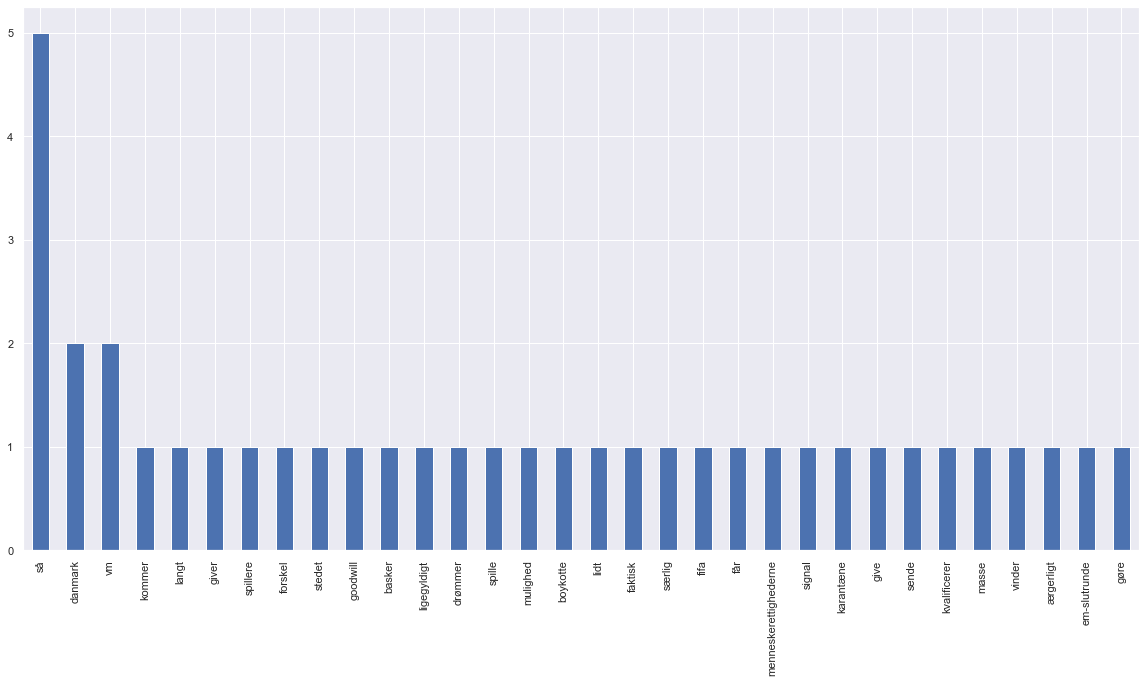

In [14]:
# visualisering

tokens_series.value_counts().plot.bar()

In [15]:
# med stanza

doc = nlp(comment)

In [16]:
for sentence in doc.sentences:
    for word in sentence.words:
        print(word.text + ", " + word.pos)

Danmark, PROPN
vinder, VERB
jo, ADV
ikke, ADV
VM, PROPN
,, PUNCT
vi, PRON
kommer, VERB
end, ADP
ikke, ADV
særlig, ADV
langt, ADV
,, PUNCT
så, SCONJ
vi, PRON
har, VERB
faktisk, ADV
en, DET
mulighed, NOUN
for, ADP
at, PART
gøre, VERB
en, DET
forskel, NOUN
for, ADP
menneskerettighederne, NOUN
her, ADV
., PUNCT
Hvis, SCONJ
vi, PRON
kvalificerer, VERB
os, PRON
,, PUNCT
så, ADV
skal, AUX
vi, PRON
boykotte, VERB
det, PRON
., PUNCT
Det, PRON
er, AUX
ligegyldigt, ADJ
om, SCONJ
FIFA, PROPN
så, ADV
giver, VERB
os, PRON
en, DET
karantæne, NOUN
., PUNCT
Det, PRON
her, ADV
vil, AUX
sende, VERB
et, DET
signal, NOUN
så, SCONJ
det, PRON
basker, VERB
., PUNCT
Det, PRON
vil, AUX
også, ADV
give, VERB
en, DET
masse, NOUN
Goodwill, NOUN
for, ADP
Danmark, PROPN
., PUNCT
Det, PRON
er, AUX
da, ADV
ærgerligt, ADJ
for, ADP
de, DET
spillere, NOUN
,, PUNCT
der, PRON
drømmer, VERB
om, ADP
at, PART
spille, VERB
VM, PROPN
., PUNCT
De, PRON
får, VERB
så, ADV
en, DET
EM-slutrunde, NOUN
om, ADP
lidt, ADV
i, ADP
stedet, 

In [17]:
def tokenizer_custom(text):
    
    stop_words = stopwords.words('danish')
    
    doc = nlp(text)
    
    pos_tags = ['PROPN', 'ADJ', 'NOUN', 'VERB'] # Keeps proper nouns, adjectives and nouns
    
    tokens = []
      
    for sentence in doc.sentences:
        for word in sentence.words:
            if (word.pos in pos_tags) and (word.text.lower() not in stop_words):
                tokens.append(word.lemma.lower())
    
    return(tokens)

In [18]:
tokenizer_custom(comment)

['danmark',
 'vinde',
 'vm',
 'komme',
 'mulighed',
 'gøre',
 'forskel',
 'menneskerettighed',
 'kvalificere',
 'boykotte',
 'ligegyldig',
 'fifa',
 'give',
 'karantæne',
 'sende',
 'signal',
 'baske',
 'give',
 'masse',
 'goodwill',
 'danmark',
 'ærgerlig',
 'spiller',
 'drømme',
 'spille',
 'vm',
 'få',
 'em-slutrunde',
 'sted']

In [19]:
posts_df = pd.DataFrame.from_records(posts)

In [20]:
posts_df_long = posts_df.explode('comments').reset_index(drop=True).add_prefix('post_')
posts_df_long = pd.merge(posts_df_long, pd.json_normalize(posts_df_long['post_comments']).add_prefix('comment_'), left_index=True, right_index=True)

In [21]:
posts_df_long.head()

,post_author,post_created_utc,post_domain,post_full_link,post_gildings,post_id,post_is_original_content,post_is_reddit_media_domain,post_locked,post_media_only,...,comment_is_submitter,comment_link_id,comment_parent_id,comment_permalink,comment_retrieved_on,comment_score,comment_stickied,comment_subreddit,comment_subreddit_id,comment_total_awards_received
0,MadsenFraMadsenOgCo,1614698948,berlingske.dk,https://www.reddit.com/r/Denmark/comments/lw4k...,{},lw4koj,False,False,False,False,...,False,t3_lw4koj,t3_lw4koj,/r/Denmark/comments/lw4koj/pfizer_med_opjuster...,1614699643,1,False,Denmark,t5_2qjto,0
1,MadsenFraMadsenOgCo,1614698948,berlingske.dk,https://www.reddit.com/r/Denmark/comments/lw4k...,{},lw4koj,False,False,False,False,...,False,t3_lw4koj,t1_gpfa37s,/r/Denmark/comments/lw4koj/pfizer_med_opjuster...,1614700857,1,False,Denmark,t5_2qjto,0
2,MadsenFraMadsenOgCo,1614698948,berlingske.dk,https://www.reddit.com/r/Denmark/comments/lw4k...,{},lw4koj,False,False,False,False,...,False,t3_lw4koj,t1_gpfcfj3,/r/Denmark/comments/lw4koj/pfizer_med_opjuster...,1614702086,1,False,Denmark,t5_2qjto,0
3,MadsenFraMadsenOgCo,1614698948,berlingske.dk,https://www.reddit.com/r/Denmark/comments/lw4k...,{},lw4koj,False,False,False,False,...,False,t3_lw4koj,t1_gpfesm5,/r/Denmark/comments/lw4koj/pfizer_med_opjuster...,1614702455,1,False,Denmark,t5_2qjto,0
4,MadsenFraMadsenOgCo,1614698948,berlingske.dk,https://www.reddit.com/r/Denmark/comments/lw4k...,{},lw4koj,False,False,False,False,...,False,t3_lw4koj,t1_gpffidu,/r/Denmark/comments/lw4koj/pfizer_med_opjuster...,1614702670,1,False,Denmark,t5_2qjto,0


In [22]:
posts_df_long.shape

(3428, 52)

In [23]:
posts_subset = posts_df_long.loc[posts_df_long['post_id'] == 'lw4koj']

In [24]:
posts_subset['comment_tokens'] = posts_subset['comment_body'].apply(tokenizer_custom)

C:\programs\Anaconda3\envs\lda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
posts_subset_tidy = posts_subset.explode('comment_tokens')

<AxesSubplot:>

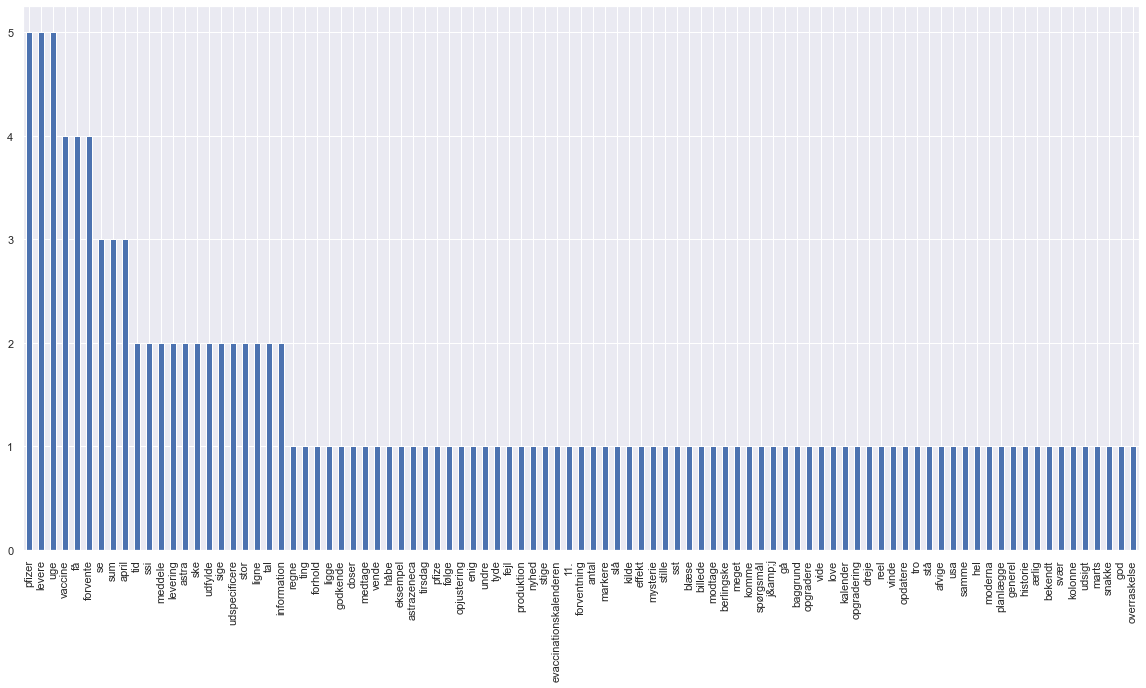

In [26]:
posts_subset_tidy['comment_tokens'].value_counts().plot.bar()

In [27]:
posts_df_long['comment_tokens'] = posts_df_long['comment_body'].apply(tokenizer_custom)

In [28]:
comments_tokens = list(posts_df_long['comment_tokens'])

In [31]:
# Create Dictionary
id2word = corpora.Dictionary(comments_tokens) # integer id per word

# Create Corpus
texts = comments_tokens

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts] # bag-of-word(bow) tuple for each text - id, count

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


In [65]:
id2word[1] # look up word based on integer id

C:\programs\Anaconda3\envs\lda\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'levering'

In [33]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('forvente', 1),
  ('levering', 1),
  ('opjustering', 1),
  ('reel', 1),
  ('sige', 1),
  ('stige', 1),
  ('svær', 1)]]

In [75]:
lda_model = LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)
lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_model)

C:\programs\Anaconda3\envs\lda\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
# Show Topics
pprint(lda_model.show_topics(formatted=False))

# Compute Coherence Score - https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf
coherence_model_lda = CoherenceModel(model=lda_model, texts=comments_tokens, dictionary=id2word, coherence='c_v')
coherence_ldamodel = coherence_model_lda.get_coherence() 
print('\nCoherence Score: ', coherence_ldamodel)

C:\programs\Anaconda3\envs\lda\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  [('se', 0.06335078534031413),
   ('tro', 0.05235602094240838),
   ('finde', 0.0356020942408377),
   ('sted', 0.031413612565445025),
   ('menneske', 0.02382198952879581),
   ('gang', 0.01806282722513089),
   ('egen', 0.014921465968586388),
   ('huske', 0.014397905759162303),
   ('holdning', 0.011256544502617802),
   ('møde', 0.010471204188481676)]),
 (1,
  [('se', 0.057971014492753624),
   ('sige', 0.03390269151138716),
   ('ting', 0.030797101449275364),
   ('bruge', 0.02303312629399586),
   ('usa', 0.016821946169772256),
   ('vide', 0.015527950310559006),
   ('sætte', 0.015269151138716356),
   ('svær', 0.014233954451345756),
   ('komme', 0.013457556935817806),
   ('forskel', 0.013198757763975156)]),
 (2,
  [('danmark', 0.041163421247227015),
   ('stor', 0.041163421247227015),
   ('mange', 0.03179689425684003),
   ('problem', 0.03155040670446142),
   ('dansk', 0.030071481390189794),
   ('land', 0.029085531180675375),
   ('samme', 0.02464875523786049),
   ('gøre', 0.02390929258072

In [78]:
pprint(lda_model.print_topics(num_words=10))

[(0,
  '0.063*"se" + 0.052*"tro" + 0.036*"finde" + 0.031*"sted" + 0.024*"menneske" '
  '+ 0.018*"gang" + 0.015*"egen" + 0.014*"huske" + 0.011*"holdning" + '
  '0.010*"møde"'),
 (1,
  '0.058*"se" + 0.034*"sige" + 0.031*"ting" + 0.023*"bruge" + 0.017*"usa" + '
  '0.016*"vide" + 0.015*"sætte" + 0.014*"svær" + 0.013*"komme" + '
  '0.013*"forskel"'),
 (2,
  '0.041*"danmark" + 0.041*"stor" + 0.032*"mange" + 0.032*"problem" + '
  '0.030*"dansk" + 0.029*"land" + 0.025*"samme" + 0.024*"gøre" + 0.020*"barn" '
  '+ 0.014*"bo"'),
 (3,
  '0.040*"få" + 0.033*"lille" + 0.027*"lave" + 0.023*"tid" + 0.023*"arbejde" + '
  '0.022*"dag" + 0.022*"læse" + 0.018*"ny" + 0.016*"gammel" + 0.015*"par"'),
 (4,
  '0.054*"tage" + 0.039*"give" + 0.031*"gå" + 0.024*"gøre" + 0.024*"penge" + '
  '0.023*"hel" + 0.022*"tænke" + 0.021*"købe" + 0.015*"spille" + '
  '0.015*"reklame"'),
 (5,
  '0.035*"komme" + 0.034*"gøre" + 0.027*"god" + 0.026*"vide" + 0.020*"person" '
  '+ 0.019*"gang" + 0.018*"få" + 0.018*"post" + 0.017*"

C:\programs\Anaconda3\envs\lda\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1]:
# Visualize the topics

#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#vis

In [74]:
#
lda_model[corpus[0]]

C:\programs\Anaconda3\envs\lda\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.1052631578947659),
 (1, 0.08913672352739513),
 (2, 0.13827443325184804),
 (3, 0.08771929824564344),
 (4, 0.10706438664975028),
 (5, 0.08829093065263273),
 (6, 0.08771929824564344),
 (7, 0.10457060694887027),
 (8, 0.1041823230789933),
 (9, 0.08777884150445736)]

In [83]:
topic_kws = [word for word, prop in lda_model.show_topic(0)]

C:\programs\Anaconda3\envs\lda\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [96]:
dominant_topic = sorted(lda_model[corpus[0]], key = lambda t: t[1], reverse = True)[0]

C:\programs\Anaconda3\envs\lda\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
topic_num = dominant_topic[0]
topic_prob = dominant_topic[1]

C:\programs\Anaconda3\envs\lda\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [100]:
# Function for getting dominant topic for one corpus entry (bag-of-word tuple - bowt)
def get_dominant_topic(corpus_bowt, ldamodel = lda_model):
    
    dominant_topic_dict = dict()
    
    topics_doc = ldamodel[corpus_bowt]
    
    dominant_topic = sorted(topics_doc, key = lambda t: t[1], reverse = True)[0]
    topic_num = dominant_topic[0]
    topic_prob = dominant_topic[1]
    
    topic_kws = [word for word, prop in ldamodel.show_topic(topic_num)]
    
    dominant_topic_dict['dominant_topic'] = topic_num
    dominant_topic_dict['topic_probability'] = topic_prob
    dominant_topic_dict['topic_keywords'] = topic_kws
    
    return(dominant_topic_dict) # Note that domninant topic info is returned as dictionary

# Creating list of dictionaries - one dictionary contatining dominant topic info for each corpus entry
corpus_dominant_topics = list()
for bowt in corpus:
    dominant_topic = get_dominant_topic(bowt)
    corpus_dominant_topics.append(dominant_topic)

# Add the dominant topic list as a series to the original data frame (NOTE: This assumes that order of entries has not been changed)    
posts_df_long['dominant_topic'] = pd.Series(corpus_dominant_topics)

# Spreading dominant topic dictionaries into columns using json_normalize
posts_df_topics = pd.merge(posts_df_long, pd.json_normalize(posts_df_long['dominant_topic']).add_prefix('comment_'), left_index=True, right_index=True)

C:\programs\Anaconda3\envs\lda\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
get_dominant_topic(corpus[0])

C:\programs\Anaconda3\envs\lda\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'dominant_topic': 1,
 'topic_probability': 0.15044273376579403,
 'topic_keywords': ['se',
  'sige',
  'ting',
  'bruge',
  'usa',
  'vide',
  'sætte',
  'svær',
  'komme',
  'forskel']}

In [110]:
posts_df_topics.head()

C:\programs\Anaconda3\envs\lda\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,post_author,post_created_utc,post_domain,post_full_link,post_gildings,post_id,post_is_original_content,post_is_reddit_media_domain,post_locked,post_media_only,...,comment_score,comment_stickied,comment_subreddit,comment_subreddit_id,comment_total_awards_received,comment_tokens,dominant_topic,comment_dominant_topic,comment_topic_probability,comment_topic_keywords
0,MadsenFraMadsenOgCo,1614698948,berlingske.dk,https://www.reddit.com/r/Denmark/comments/lw4k...,{},lw4koj,False,False,False,False,...,1,False,Denmark,t5_2qjto,0,"[svær, sige, reel, opjustering, forvente, leve...","{'dominant_topic': 1, 'topic_probability': 0.1...",1,0.150439,"[se, sige, ting, bruge, usa, vide, sætte, svær..."
1,MadsenFraMadsenOgCo,1614698948,berlingske.dk,https://www.reddit.com/r/Denmark/comments/lw4k...,{},lw4koj,False,False,False,False,...,1,False,Denmark,t5_2qjto,0,"[enig, april, markere, generel, vaccine, uge, ...","{'dominant_topic': 7, 'topic_probability': 0.1...",7,0.153347,"[&gt, skrive, betale, spørgsmål, kommentar, st..."
2,MadsenFraMadsenOgCo,1614698948,berlingske.dk,https://www.reddit.com/r/Denmark/comments/lw4k...,{},lw4koj,False,False,False,False,...,1,False,Denmark,t5_2qjto,0,[astra],"{'dominant_topic': 8, 'topic_probability': 0.1...",8,0.117647,"[år, få, høre, holde, krone, god, [deleted], m..."
3,MadsenFraMadsenOgCo,1614698948,berlingske.dk,https://www.reddit.com/r/Denmark/comments/lw4k...,{},lw4koj,False,False,False,False,...,1,False,Denmark,t5_2qjto,0,"[snakke, stå, se, ligne, uge]","{'dominant_topic': 3, 'topic_probability': 0.1...",3,0.127273,"[få, lille, lave, tid, arbejde, dag, læse, ny,..."
4,MadsenFraMadsenOgCo,1614698948,berlingske.dk,https://www.reddit.com/r/Denmark/comments/lw4k...,{},lw4koj,False,False,False,False,...,1,False,Denmark,t5_2qjto,0,"[bekendt, få, astra, pfizer, tyde, billede, ki...","{'dominant_topic': 8, 'topic_probability': 0.1...",8,0.143286,"[år, få, høre, holde, krone, god, [deleted], m..."


In [111]:
posts_df_topics['comment_dominant_topic'].value_counts()

C:\programs\Anaconda3\envs\lda\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    531
8    458
4    336
2    317
5    313
6    302
1    300
7    300
9    292
3    279
Name: comment_dominant_topic, dtype: int64

In [112]:
posts_df_topics_tidy = posts_df_topics.explode('comment_tokens')

C:\programs\Anaconda3\envs\lda\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [126]:
posts_df_topics_tidy.loc[posts_df_topics_tidy['comment_dominant_topic'] == 6, 'comment_tokens'].value_counts()[0:50]

C:\programs\Anaconda3\envs\lda\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


god           48
mene          45
få            38
sige          38
se            34
stor          31
våben         30
komme         28
tro           26
gøre          26
vise          23
bruge         23
gå            23
ret           22
grund         21
side          21
ai            21
lyde          20
enig          19
folk          18
år            18
synes         18
forstå        17
vinkel        16
situation     16
første        16
tænke         15
grad          15
ændre         14
dårlig        14
pointe        14
give          14
måde          14
vej           14
betyde        14
argument      14
samme         13
verden        13
tage          13
konsekvens    13
land          12
meget         12
stat          12
&gt           12
finde         11
stå           11
lære          10
danmark       10
beskrive      10
mulighed      10
Name: comment_tokens, dtype: int64